### Building Chatbot With Multiple Tools Using Langgraph

#### Aim
Create a chatbot with tool capabilities from arxiv, wikipedia search and some functions

In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [3]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [6]:
arxiv.invoke("Attention Is All You Need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [7]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [8]:
wiki.invoke("What is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [9]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")



In [10]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

C:\Users\Admin\AppData\Local\Temp\ipykernel_4240\3584238.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [11]:
tavily.invoke("Provide me the recent AI news for december 25th 2025")

[{'title': 'December 2025 round-up of interesting AI news and announcements',
  'url': 'https://nationalcentreforai.jiscinvolve.org/wp/2025/12/18/december-2025-round-up-of-interesting-ai-news-and-announcements/',
  'content': 'AI can help shift education toward deeper human engagement by automating administrative work and enabling personalised instruction. The post',
  'score': 0.8482825},
 {'title': 'the year AI got personal – DW – 12/25/2025',
  'url': 'https://www.dw.com/en/2025-the-year-ai-got-personal/av-75306917',
  'content': "### Generative AI videos: Can you tell real from fake?\n\nNavigation satellite in Earth orbit\nNavigation satellite in Earth orbit\n\n### Data centers in space: Solution or disaster?\n\nSymbolbild Smartphone Überwachung\nSymbolbild Smartphone Überwachung\n\n### Security or surveillance: Where do we draw the line?\n\n## More from this show\n\nThe Palantir logo is superimposed on a binary code\nThe Palantir logo is superimposed on a binary code\n\n### Palant

In [12]:
### Combine all the tools in the list

tools=[arxiv,wiki,tavily]

In [13]:
## Initialize my LLM model

from langchain_groq import ChatGroq

llm=ChatGroq(model="qwen/qwen3-32b")

llm_with_tools=llm.bind_tools(tools)

In [14]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent AI news. I need to figure out which tool to use here. Let me check the available functions.\n\nThe tools provided are arxiv, wikipedia, and tavily_search_results_json. Arxiv is for scientific papers, wikipedia for general knowledge, and tavily is for current events. Since the user is asking about recent news, tavily_search_results_json seems appropriate. \n\nI should use tavily to get the latest AI news. The query parameter should be "recent AI news". Let me structure the tool call correctly. Make sure the JSON is properly formatted with the function name and arguments. No need for other tools here. Alright, that should do it.\n', 'tool_calls': [{'id': 'max27z83y', 'function': {'arguments': '{"query":"recent AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 171, 'prompt_tokens': 399, 'total_tokens': 570, 'comp

In [15]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': '37k3yw2m5',
  'type': 'tool_call'}]

In [16]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

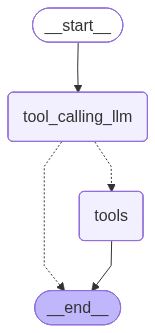

In [17]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [18]:
messages=graph.invoke({"messages":HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (n17td1pr1)
 Call ID: n17td1pr1
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, base


In [19]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news for december 25th 2025")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for december 25th 2025
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (qv31jbkdv)
 Call ID: qv31jbkdv
  Args:
    query: top 10 AI news December 25th 2025
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Top AI News for December 2025: Breakthroughs ...", "url": "https://www.aiapps.com/blog/ai-news-december-2025-breakthroughs-launches-trends/", "content": "December 2025 has brought forward some exciting developments in artificial intelligence, pushing its capabilities and applications to new levels. These advancements are already making their way into practical use across various industries.\n\n### New AI Applications in Healthcare and Diagnostics [...] As December 2025 wraps up, the AI industry continues to make stride

In [20]:
messages=graph.invoke({"messages":HumanMessage(content="What is machine learning")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (rj6w6vbb0)
 Call ID: rj6w6vbb0
  Args:
    query: machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
